<a href="https://colab.research.google.com/github/Ganesh1009/MachineLearning/blob/master/GP_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

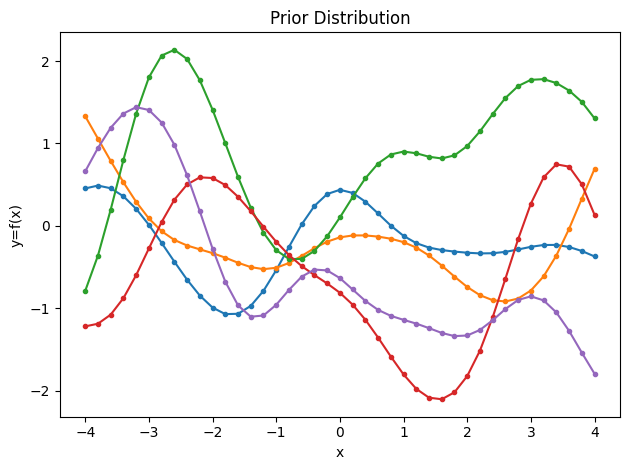

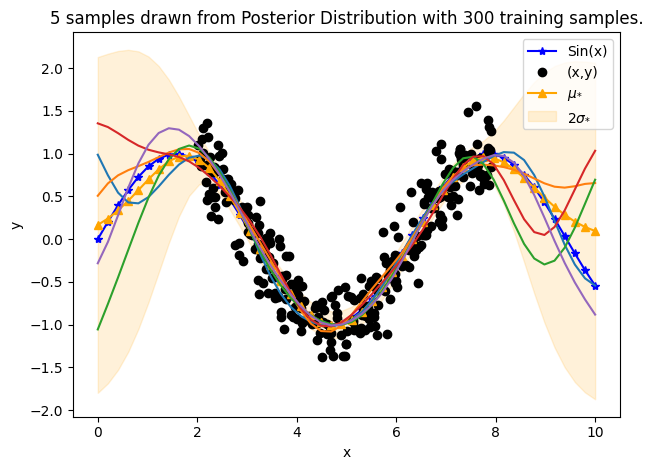

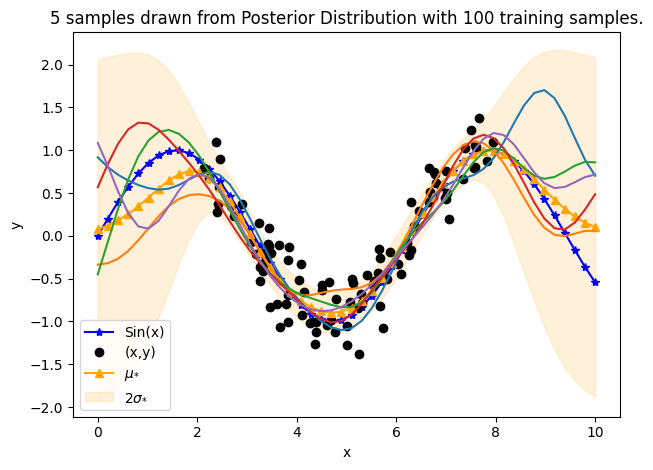

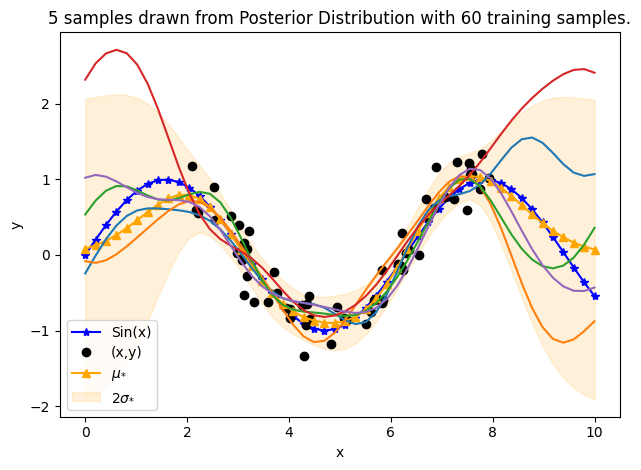

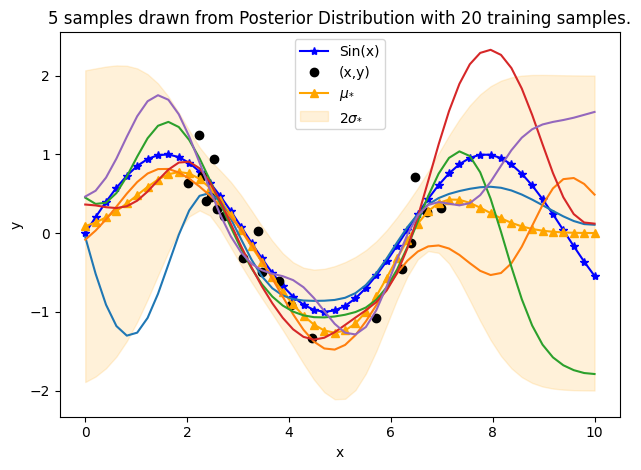

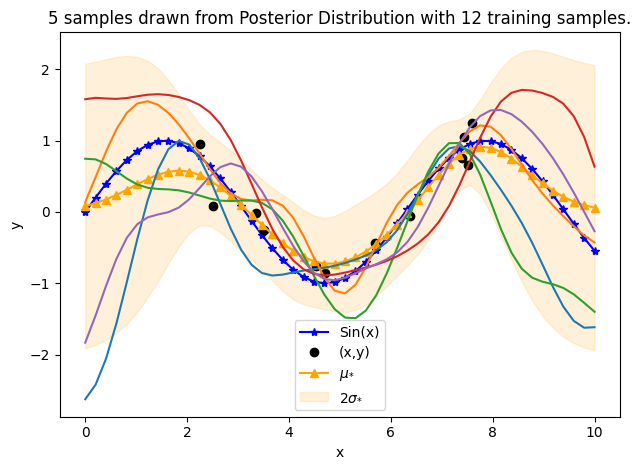

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd


def f(X):
  return np.sin(X)

def RBF(X1,X2):
  sq_norm = -0.5 * scipy.spatial.distance.cdist(X1, X2, 'sqeuclidean')
  cov = np.exp(sq_norm)  # Kernel of data points
  return cov

def GP(X1,X2,Y,kernel_func):

  K_X1X1 = kernel_func(X1,X1) + ((0.5**2)*np.eye(np.shape(X1)[0]))

  K_X1X2 = kernel_func(X1,X2)

  K_X2X2 = kernel_func(X2,X2)

  K_X2X1 = K_X1X2.transpose()

  post_mean = K_X2X1@np.linalg.inv(K_X1X1)@Y
  post_cov = K_X2X2 - K_X2X1@np.linalg.inv(K_X1X1)@K_X1X2

  return post_mean, post_cov

nb_of_samples = 41  # Number of points in each function
number_of_functions = 5  # Number of functions to sample

X = np.expand_dims(np.linspace(-4, 4, nb_of_samples), 1)
cov_ = RBF(X,X)

# Sampling from Prior distribution
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples),
    cov=cov_,
    size=number_of_functions)

x_df = pd.DataFrame(X,columns=['T'])
y_df = pd.DataFrame(ys).transpose()
df = pd.concat([x_df,y_df],axis=1)

for i in range(number_of_functions):
  plt.plot(X, ys[i], marker='o', markersize = 3)

plt.title('Prior Distribution')
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.tight_layout()
plt.savefig("Prior.svg")
plt.show()

num_of_train_samp = 300
num_of_test_samp = 50
total_range = (0,10)

for reps in range(1,61,2):

   if num_of_train_samp%reps == 0:

      noise = (0.5**2) * np.random.randn(int(num_of_train_samp/(reps))).reshape(-1,1)

      # Training data samples (X,Y)
      X1 = np.random.uniform(low=total_range[0]+2,
                             high=total_range[1]-2,
                             size=(int(num_of_train_samp/(reps)),1))
      Y = f(X1) + noise

      # Test sample location (X*)
      X2 = np.linspace(start=total_range[0],
                       stop=total_range[1],
                       num=num_of_test_samp
                       ).reshape(-1,1)

      post_mean, post_cov = GP(X1,X2,Y,RBF)
      Y2 = np.random.multivariate_normal(mean=post_mean.squeeze(),
                                         cov=post_cov,
                                         size=number_of_functions)

      std_dev = np.sqrt(np.diag(post_cov))

      plt.plot(X2,f(X2),marker='*',color='blue', label='Sin(x)')
      plt.plot(X1,Y,'o',color='black',label='(x,y)')
      plt.plot(X2,post_mean,marker='^',color='orange',label='$\mu_{*}$')
      plt.fill_between(x=X2.squeeze(),
                       y1=post_mean.squeeze()-2*std_dev,
                       y2=post_mean.squeeze()+2*std_dev,
                       alpha=0.15,
                       color='orange',
                       label="2$\sigma_{*}$"
                       )
      plt.title('Posterior and Prior Distribution')
      plt.xlabel('x')
      plt.ylabel('y')
      plt.legend()
      plt.tight_layout()
      # plt.savefig("GP_regression.svg")

      for i in range(number_of_functions):
        plt.plot(X2.squeeze(), Y2[i].transpose())
      plt.xlabel('x')
      plt.ylabel('y')
      plt.title('5 samples drawn from Posterior Distribution with ' + str(int(num_of_train_samp/(reps))) + " training samples.")
      plt.tight_layout()
      plt.savefig("Posterior"+str(reps)+".svg")
      plt.show()